In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from gluonts.dataset.split import split
from gluonts.dataset.common import (
    MetaData,
    TrainDatasets,
    FileDataset,
)
plt.style.use('seaborn')

/tmp/ipykernel_42801/3732702600.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def get_custom_dataset(
    jsonl_path: Path,
    freq: str,
    prediction_length: int,
    split_offset: int = None,
):
    """Creates a custom GluonTS dataset from a JSONLines file and
    give parameters.

    Parameters
    ----------
    jsonl_path
        Path to a JSONLines file with time series
    freq
        Frequency in pandas format
        (e.g., `H` for hourly, `D` for daily)
    prediction_length
        Prediction length
    split_offset, optional
        Offset to split data into train and test sets, by default None

    Returns
    -------
        A gluonts dataset
    """
    if split_offset is None:
        split_offset = -prediction_length

    metadata = MetaData(freq=freq, prediction_length=prediction_length)
    test_ts = FileDataset(jsonl_path, freq)
    train_ts, _ = split(test_ts, offset=split_offset)
    dataset = TrainDatasets(metadata=metadata, train=train_ts, test=test_ts)
    return dataset

In [3]:
dataset = get_custom_dataset('datasets/btc-usd_dataset.jsonl', freq='D', prediction_length=30)

In [4]:
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

# Initialize the DeepAR estimator
deepar_estimator = DeepAREstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=200,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
deepar_predictor = deepar_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:06<00:00, 15.53it/s, epoch=200/200, avg_epoch_loss=-4.43]


In [5]:
from gluonts.mx.model.transformer import TransformerEstimator

# Initialize the Transformer estimator
transformer_estimator = TransformerEstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=200,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
transformer_predictor = transformer_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:04<00:00, 23.26it/s, epoch=200/200, avg_epoch_loss=-3.56]


In [6]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

def evaluate_model(predictor, test_data):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(tss, forecasts, num_series=len(test_data))

    for i, (ts_entry, forecast_entry) in enumerate(zip(tss, forecasts)):
        # Plot and save each time series and forecast comparison
        plt.figure(figsize=(10, 5))
        plt.plot(ts_entry[-150:].to_timestamp(), label='Actual')  # Adjust the slicing according to your data
        forecast_entry.plot(color='crimson', label='Forecast')
        plt.legend()
        plt.title(f'Forecast vs Actuals for Series {i}')
        # plt.savefig(os.path.join(output_dir, f'forecast_plot_{i}.png'))  # Save the plot as a PNG file
        plt.plot()

    return agg_metrics, item_metrics


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


DeepAR Evaluation Metrics: {'MSE': 0.0010924494514862697, 'abs_error': 0.6987292170524597, 'abs_target_sum': 0.5326324105262756, 'abs_target_mean': 0.01775441368420919, 'seasonal_error': 0.03622213611642508, 'MASE': 0.6430038754999672, 'MAPE': 1.5459898630777995, 'sMAPE': 1.5803262074788411, 'MSIS': 17.962908588573764, 'QuantileLoss[0.1]': 0.5503503669984638, 'Coverage[0.1]': 0.36666666666666664, 'QuantileLoss[0.2]': 0.6156056774780155, 'Coverage[0.2]': 0.36666666666666664, 'QuantileLoss[0.3]': 0.6542604687623679, 'Coverage[0.3]': 0.36666666666666664, 'QuantileLoss[0.4]': 0.6827751900535075, 'Coverage[0.4]': 0.4, 'QuantileLoss[0.5]': 0.6987292957492173, 'Coverage[0.5]': 0.4666666666666667, 'QuantileLoss[0.6]': 0.7062006788328291, 'Coverage[0.6]': 0.4666666666666667, 'QuantileLoss[0.7]': 0.6999236756935715, 'Coverage[0.7]': 0.4666666666666667, 'QuantileLoss[0.8]': 0.6773874199017881, 'Coverage[0.8]': 0.5666666666666667, 'QuantileLoss[0.9]': 0.6446276274975389, 'Coverage[0.9]': 0.6, 'RMS

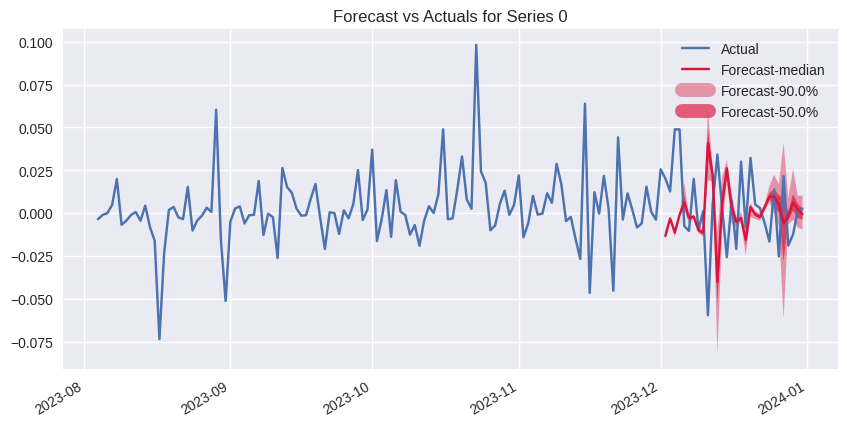

In [7]:
deepar_metrics, _ = evaluate_model(deepar_predictor, dataset.test)
print("DeepAR Evaluation Metrics:", deepar_metrics)


Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Transformer Evaluation Metrics: {'MSE': 0.000840528371433417, 'abs_error': 0.6705449819564819, 'abs_target_sum': 0.5326324105262756, 'abs_target_mean': 0.01775441368420919, 'seasonal_error': 0.03622213611642508, 'MASE': 0.6170674011799657, 'MAPE': 1.9639169057210286, 'sMAPE': 1.5684378306070963, 'MSIS': 8.25118698191382, 'QuantileLoss[0.1]': 0.4047404109616765, 'Coverage[0.1]': 0.3333333333333333, 'QuantileLoss[0.2]': 0.557329417578876, 'Coverage[0.2]': 0.36666666666666664, 'QuantileLoss[0.3]': 0.6251374918967485, 'Coverage[0.3]': 0.4, 'QuantileLoss[0.4]': 0.6627074254676699, 'Coverage[0.4]': 0.4, 'QuantileLoss[0.5]': 0.6705449384171516, 'Coverage[0.5]': 0.43333333333333335, 'QuantileLoss[0.6]': 0.6524803829379379, 'Coverage[0.6]': 0.43333333333333335, 'QuantileLoss[0.7]': 0.6145082940813154, 'Coverage[0.7]': 0.4666666666666667, 'QuantileLoss[0.8]': 0.5367595087736844, 'Coverage[0.8]': 0.5666666666666667, 'QuantileLoss[0.9]': 0.419827098143287, 'Coverage[0.9]': 0.6333333333333333, 'RMS

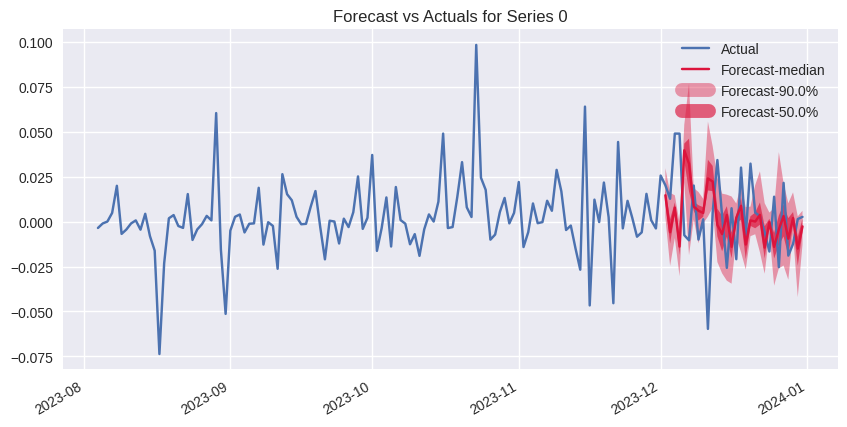

In [8]:
transformer_metrics, _ = evaluate_model(transformer_predictor, dataset.test)
print("Transformer Evaluation Metrics:", transformer_metrics)
